# 소리 검색 - Urban Sound

modified from https://github.com/aqibsaeed/Urban-Sound-Classification/blob/master/Convolutional%20Neural%20Network.ipynb

data from UrbanSound https://urbansounddataset.weebly.com/urbansound8k.html

# 데이터 준비

In [ ]:
!wget -O UrbanSound8K.tar.gz https://goo.gl/8hY5ER

--2022-01-26 05:00:58--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 173.194.210.101, 173.194.210.102, 173.194.210.113, ...
Connecting to goo.gl (goo.gl)|173.194.210.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2022-01-26 05:00:58--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound9K.tar.gz’

UrbanSound9K.tar.gz 100%[===================>]   5.61G  19.9MB/s    in 8m 9s   

2022-01-26 05:09:09 (11.8 MB/s) - ‘UrbanSound9K.tar.gz’ saved [6023741708/6023741708]



In [ ]:
!tar xvfz UrbanSound8K.tar.gz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
UrbanSound8K/audio/fold4/17480-2-0-6.wav
UrbanSound8K/audio/fold4/17480-2-0-9.wav
UrbanSound8K/audio/fold4/175904-2-0-11.wav
UrbanSound8K/audio/fold4/175904-2-0-24.wav
UrbanSound8K/audio/fold4/176003-1-0-0.wav
UrbanSound8K/audio/fold4/176638-5-0-0.wav
UrbanSound8K/audio/fold4/177756-2-0-10.wav
UrbanSound8K/audio/fold4/177756-2-0-4.wav
UrbanSound8K/audio/fold4/177756-2-0-5.wav
UrbanSound8K/audio/fold4/177756-2-0-7.wav
UrbanSound8K/audio/fold4/179862-1-0-0.wav
UrbanSound8K/audio/fold4/180977-3-1-1.wav
UrbanSound8K/audio/fold4/180977-3-1-5.wav
UrbanSound8K/audio/fold4/183989-3-1-21.wav
UrbanSound8K/audio/fold4/183989-3-1-23.wav
UrbanSound8K/audio/fold4/185709-0-0-0.wav
UrbanSound8K/audio/fold4/185709-0-0-1.wav
UrbanSound8K/audio/fold4/185709-0-0-6.wav
UrbanSound8K/audio/fold4/185709-0-0-7.wav
UrbanSound8K/audio/fold4/185909-2-0-102.wav
UrbanSound8K/audio/fold4/185909-2-0-13.wav
UrbanSound8K/audio/fold4/185909-2-0-17.wav
UrbanSound8K/audio/fold4/185909-2

In [ ]:
import pandas as pd
metadata_df = pd.read_csv('./UrbanSound8K/metadata/UrbanSound8K.csv')
metadata_df

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
...,...,...,...,...,...,...,...,...
8727,99812-1-2-0.wav,99812,159.522205,163.522205,2,7,1,car_horn
8728,99812-1-3-0.wav,99812,181.142431,183.284976,2,7,1,car_horn
8729,99812-1-4-0.wav,99812,242.691902,246.197885,2,7,1,car_horn
8730,99812-1-5-0.wav,99812,253.209850,255.741948,2,7,1,car_horn


In [ ]:
import IPython.display as ipd
display(ipd.Audio('./UrbanSound8K/audio/fold1/108041-9-0-5.wav'))
display(ipd.Audio('./UrbanSound8K/audio/fold5/100852-0-0-19.wav'))

In [ ]:
import librosa

sound_clip, sampling_ratio = librosa.load('./UrbanSound8K/audio/fold1/108041-9-0-5.wav')

import matplotlib.pyplot as plt
print(type(sound_clip))
print(sound_clip.shape)
print(sound_clip[:10])
print("sampling_ratio =",sampling_ratio)

import IPython
IPython.display.Audio(data=sound_clip, rate=sampling_ratio)

<class 'numpy.ndarray'>
(88200,)
[-0.03148247 -0.06967403 -0.02807479  0.07812583  0.10158778  0.08008352
  0.09629877  0.1579831   0.25382036  0.27910018]
sampling_ratio = 22050


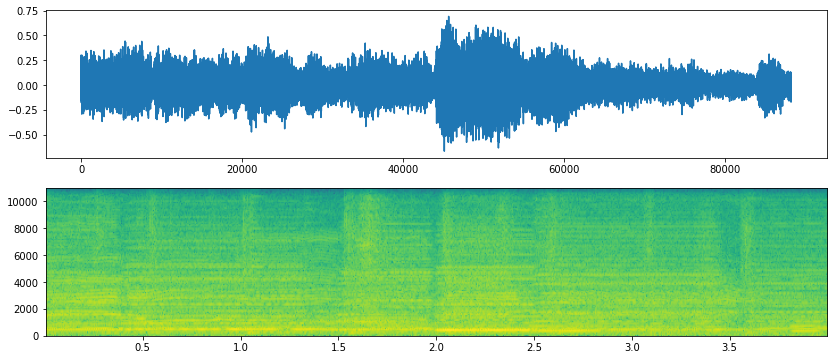

In [ ]:
plt.figure(figsize=(14,6))
plt.subplot(211)
plt.plot(sound_clip)

plt.subplot(212)
plt.specgram(sound_clip,Fs=sampling_ratio)

plt.show()

# 데이터 로딩

In [ ]:
import glob
import os
import librosa
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

In [ ]:
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

data_root_path = "UrbanSound8K/audio"
metadata_df['file_names'] = data_root_path+"/fold"+metadata_df['fold'].astype(str)+"/"+metadata_df['slice_file_name']
metadata_df

file_names = metadata_df.file_names.values
print(file_names[:5])
print(type(file_names))

labels = metadata_df['classID'].astype(int).values

print(labels[:5])

['UrbanSound8K/audio/fold5/156634-5-0-5.wav'
 'UrbanSound8K/audio/fold9/159744-8-0-7.wav'
 'UrbanSound8K/audio/fold4/171305-7-9-0.wav'
 'UrbanSound8K/audio/fold6/159702-6-3-0.wav'
 'UrbanSound8K/audio/fold3/112075-5-0-0.wav']
<class 'numpy.ndarray'>
[5 8 7 6 5]


In [ ]:
data_count = len(file_names)
train_count = int(data_count*0.8)
print(data_count)

train_file_names = file_names[:train_count]
train_labels = labels[:train_count]
test_file_names = file_names[train_count:]
test_labels = labels[train_count:]
print(len(train_file_names), len(test_file_names))

8732
6985 1747


# Data Generator

In [ ]:
BATCH_SIZE = 32

In [ ]:
import numpy as np
import math
import random
from tensorflow.keras.utils import Sequence
import glob
import os
import librosa

WAVE_SIZE = 40000

class DataGenerator(Sequence):

    def __init__(self, file_names, labels, batch_size=BATCH_SIZE, shuffle=True, max_size=9999999, use_cache=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.sound_clips = None
        self.labels = None
        self._preload(file_names, labels, max_size, use_cache)
        self.indexes = np.arange(len(self.sound_clips))
        self._shuffle()

    def __len__(self):
        return math.ceil(len(self.indexes)/ self.batch_size)

    def _load_sound(self, file_name):
        sound_clip, sampling_ratio = librosa.load(file_name)
        return sound_clip

    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_x = self.sound_clips[indexes]
        batch_y = self.labels[indexes]
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle: self._shuffle()

    def _shuffle(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _preload(self, file_names, file_labels, max_size, use_cache):

        CACHE_FILE_NAME = "preloaded_cache.npy"
        if use_cache and os.path.isfile(CACHE_FILE_NAME):
            loaded_cache = np.load(CACHE_FILE_NAME, allow_pickle=True).item()
            self.sound_clips = loaded_cache['sound_clips']
            self.labels = loaded_cache['labels']
            print(f"data loaded from cache file {CACHE_FILE_NAME}. {len(self.sound_clips)} images.")
            return

        sound_clips = []
        labels = []
        for file_name, label in zip(file_names, file_labels):
            sound_clip  = self._load_sound(file_name)
            if len(sound_clip)<WAVE_SIZE:
                print(f"short sound_clip. length {len(sound_clip)}. {file_name}")
                continue
            sound_clip = sound_clip[:WAVE_SIZE]
            sound_clips.append(sound_clip)
            labels.append(label)
            if len(sound_clips)>=max_size: break
            if len(sound_clips)%10==0:
                print(f"{len(sound_clips)}/{min(max_size, len(file_names))} file loaded.")
        self.sound_clips = np.array(sound_clips)
        self.labels = np.array(labels)
        if use_cache:
            np.save(CACHE_FILE_NAME, {"sound_clips":self.sound_clips, "labels":self.labels})
            print(f"data saved to cache file {CACHE_FILE_NAME}")

In [ ]:
train_data_generator = DataGenerator(train_file_names, train_labels, max_size=9999, use_cache=False)

batch_x, batch_y = train_data_generator.__getitem__(0)
print(batch_x.shape)
print(batch_y.shape)
print(batch_y)

import IPython
IPython.display.Audio(data=batch_x[0], rate=22050)

short sound_clip. length 27685. UrbanSound8K/audio/fold4/171305-7-9-0.wav
short sound_clip. length 14030. UrbanSound8K/audio/fold6/159702-6-3-0.wav
10/6985 file loaded.
short sound_clip. length 20948. UrbanSound8K/audio/fold9/180029-4-15-0.wav
20/6985 file loaded.
short sound_clip. length 29768. UrbanSound8K/audio/fold1/46656-6-5-0.wav
30/6985 file loaded.
short sound_clip. length 19184. UrbanSound8K/audio/fold1/165645-4-4-0.wav
short sound_clip. length 3749. UrbanSound8K/audio/fold9/155130-1-0-0.wav
short sound_clip. length 11687. UrbanSound8K/audio/fold2/34621-4-22-0.wav
40/6985 file loaded.
short sound_clip. length 13188. UrbanSound8K/audio/fold9/180156-1-8-0.wav
short sound_clip. length 13671. UrbanSound8K/audio/fold6/9032-3-1-0.wav
short sound_clip. length 32308. UrbanSound8K/audio/fold4/22883-7-48-0.wav
50/6985 file loaded.
60/6985 file loaded.
short sound_clip. length 25560. UrbanSound8K/audio/fold1/162703-1-0-0.wav
70/6985 file loaded.
80/6985 file loaded.
90/6985 file loaded.


In [ ]:
test_data_generator = DataGenerator(test_file_names, test_labels, max_size=99999, use_cache=False)

10/1747 file loaded.
20/1747 file loaded.
short sound_clip. length 2404. UrbanSound8K/audio/fold1/87275-1-5-0.wav
30/1747 file loaded.
short sound_clip. length 29988. UrbanSound8K/audio/fold9/180029-4-10-0.wav
40/1747 file loaded.
50/1747 file loaded.
60/1747 file loaded.
short sound_clip. length 32855. UrbanSound8K/audio/fold4/175846-1-0-0.wav
short sound_clip. length 39690. UrbanSound8K/audio/fold10/162134-7-6-0.wav
short sound_clip. length 34074. UrbanSound8K/audio/fold4/171305-7-23-0.wav
70/1747 file loaded.
80/1747 file loaded.
short sound_clip. length 29988. UrbanSound8K/audio/fold5/162432-6-9-0.wav
90/1747 file loaded.
short sound_clip. length 33957. UrbanSound8K/audio/fold2/34621-4-2-0.wav
short sound_clip. length 31091. UrbanSound8K/audio/fold9/72723-3-0-0.wav
100/1747 file loaded.
short sound_clip. length 31973. UrbanSound8K/audio/fold6/125574-3-0-0.wav
110/1747 file loaded.
120/1747 file loaded.
130/1747 file loaded.
short sound_clip. length 24476. UrbanSound8K/audio/fold1/1

In [ ]:
INPUT_SHAPE = batch_x[0].shape
print(INPUT_SHAPE)

classes = np.unique(labels)
print(classes)
CLASS_NUM = max(classes)+1
print(CLASS_NUM)

(40000,)
[0 1 2 3 4 5 6 7 8 9]
10


# 모델 정의

In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, RepeatVector, Flatten, Input, Reshape
from tensorflow.keras.layers import Bidirectional, LSTM, GRU, Conv1D, BatchNormalization

input_shape = INPUT_SHAPE

model = keras.Sequential()
model.add(Input(input_shape))
model.add(Reshape((INPUT_SHAPE[0],1)))
model.add(Conv1D(32, 151, padding="same"))
model.add(Conv1D(32, 151, padding="same"))
model.add(Bidirectional(LSTM(128)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(CLASS_NUM, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
model.summary()

history = model.fit(train_data_generator, epochs=5, validation_data=test_data_generator)



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 40000, 1)          0         
                                                                 
 conv1d_14 (Conv1D)          (None, 40000, 32)         4864      
                                                                 
 conv1d_15 (Conv1D)          (None, 40000, 32)         154656    
                                                                 
 bidirectional_5 (Bidirectio  (None, 256)              164864    
 nal)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 32)                8224      
                                                      

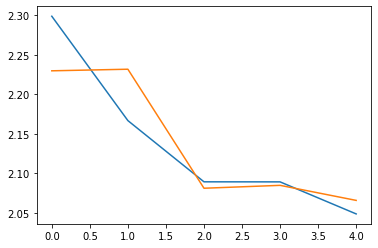

50/50 [==============================] - 66s 1s/step - loss: 2.0660 - acc: 0.2394
loss= 2.0659689903259277
acc= 0.2393650859594345


In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

loss, acc = model.evaluate(test_data_generator)
print("loss=", loss)
print("acc=", acc)


# 검색

## train 데이터에 대한 인코딩

In [ ]:
encoder = keras.Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

sound_clips = train_data_generator.sound_clips
codes = encoder.predict(sound_clips)

## test 데이터에 대한 인코딩

In [ ]:
test_sound_clips = test_data_generator.sound_clips[:32]
target_codes = encoder.predict(test_sound_clips)

## 거리 구하기

In [ ]:
from scipy.spatial import distance
import IPython

target_sound_clip = test_sound_clips[31]
target_code = target_codes[31]

distances = [distance.euclidean(target_code, code) for code in codes]
similar_index = np.argsort(distances)


## 확인

In [ ]:
IPython.display.Audio(data=target_sound_clip, rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[0]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[1]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[2]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[3]], rate=22050)

In [ ]:
IPython.display.Audio(data=sound_clips[similar_index[4]], rate=22050)

Epoch 1/60
 87/196 [============>.................] - ETA: 6:30 - loss: 1.9775 - acc: 0.2502